# Training scripts V2_1

This script contains many different pieces/steps of the model training.
Compared to the V2 notebook, there were some adjustments made to the decison tree and random forest models. 
Also the graphs to measure and compare the models performance were created and added.

## Loading the dataset
Prepared from the dataset_cleaning script

In [1]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

filepath = "final_dataset.csv"

final_dataset = pd.read_csv(filepath)

## Additional dataset preparation (sort life expectancy ascending)

In [2]:
final_dataset = final_dataset.sort_values(by=['Life Expectancy'])

## Additional dataset preparation (stratified split)

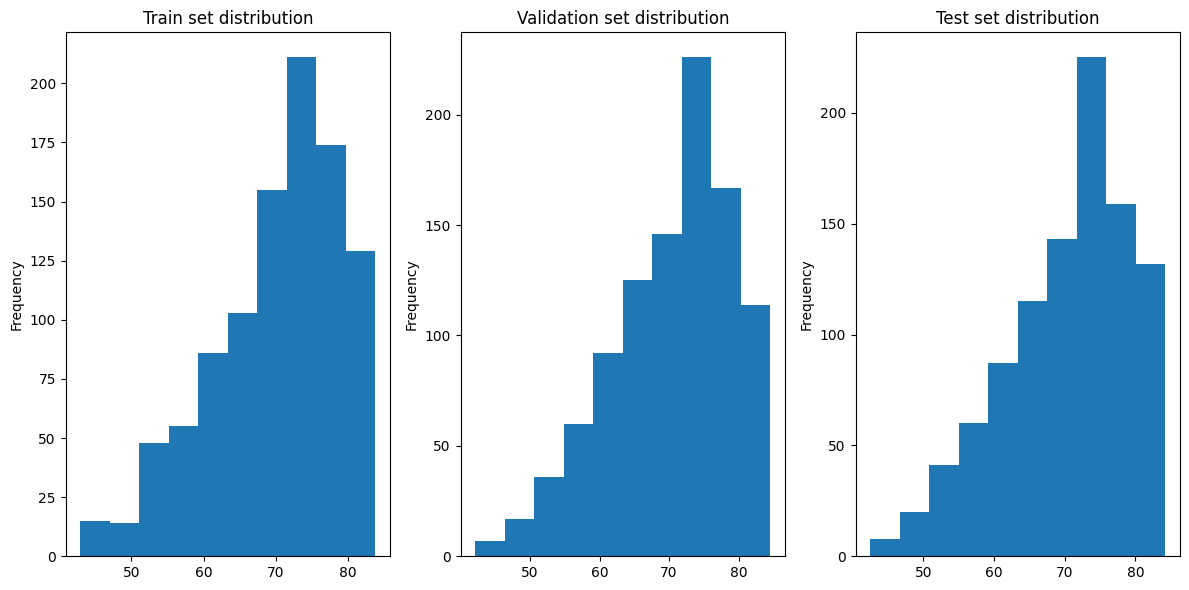

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the target variable
target = 'Life Expectancy'

# Stratify bins for the target variable to ensure distribution
# Creating bins to stratify the target variable
num_bins = 10
final_dataset['stratify_bins'] = pd.qcut(final_dataset[target], q=num_bins, duplicates='drop')

# Step 1: Split data into train_temp (2/3 of data) and test (1/3 of data)
train_temp, test = train_test_split(
    final_dataset,
    test_size=1/3,
    stratify=final_dataset['stratify_bins'],
    random_state=42
)

# Step 2: Split train_temp into train (1/2 of remaining data) and validation (1/2 of remaining data)
train, validation = train_test_split(
    train_temp,
    test_size=0.5,
    stratify=train_temp['stratify_bins'],
    random_state=42
)

# Remove the helper stratification column
train = train.drop(columns=['stratify_bins'])
validation = validation.drop(columns=['stratify_bins'])
test = test.drop(columns=['stratify_bins'])

# plot the distribution of the target variable in the train, validation, and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
train[target].plot.hist(title='Train set distribution')
plt.subplot(1, 3, 2)
validation[target].plot.hist(title='Validation set distribution')
plt.subplot(1, 3, 3)
test[target].plot.hist(title='Test set distribution')
plt.tight_layout()
plt.show()


# Split the dataset

In [4]:
# column 1 to end are features, column 0 is the target
X_train = train[train.columns[1:]]
y_train = train[train.columns[0]]

X_test = test[test.columns[1:]]
y_test = test[test.columns[0]]

X_val = validation[validation.columns[1:]]
y_val = validation[validation.columns[0]]

## Train a simple decision tree with cross validation


In [5]:
# Initialize lists to store metrics and feature importances
r2_scores = []
mae_scores = []
mse_scores = []
feature_importances = []

# Setup K-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross validation
for train_index, val_index in kf.split(X_train):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train model
    model = DecisionTreeRegressor(max_depth=4, random_state=42)
    model.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val)
    
    # Store metrics
    r2_scores.append(r2_score(y_fold_val, y_pred))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
    mse_scores.append(mean_squared_error(y_fold_val, y_pred))
    feature_importances.append(model.feature_importances_)

## Decision Tree performance graphs

<Figure size 1200x800 with 0 Axes>

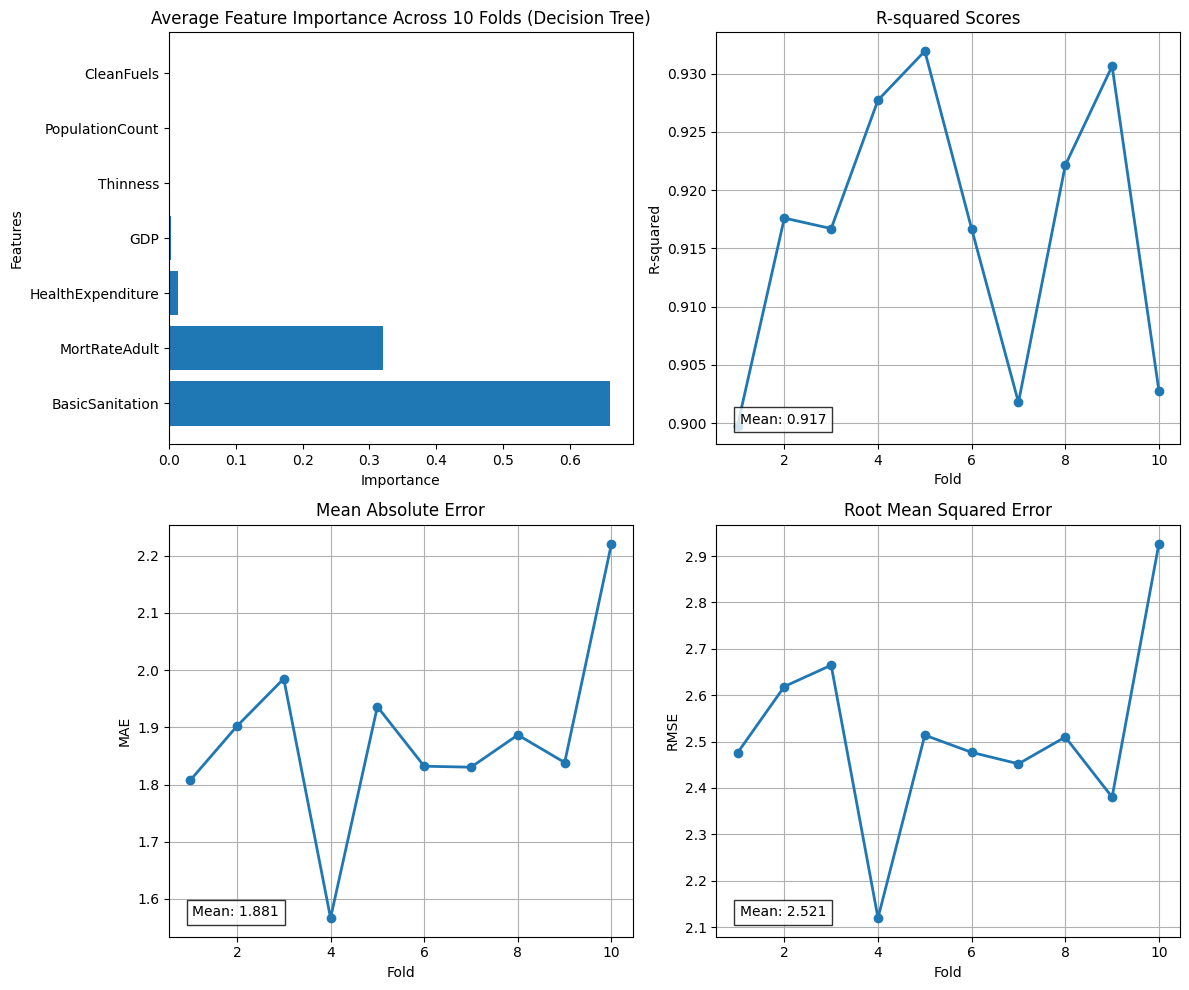

Decision Tree Metrics:
Average R-squared: 0.917 (+/- 0.011)
Average MAE: 1.881 (+/- 0.155)
Average RMSE: 2.521 (+/- 0.997)


In [6]:
# Calculate mean metrics
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.sqrt(np.mean(mse_scores))  # Convert MSE to RMSE
std_r2 = np.std(r2_scores)
std_mae = np.std(mae_scores)
std_rmse = np.sqrt(np.std(mse_scores))  # Convert MSE std to RMSE std

# Convert feature importances to array for easier plotting
feature_importances = np.array(feature_importances)
mean_importance = np.mean(feature_importances, axis=0)

# Plot feature importances (bar plot)
plt.figure(figsize=(12, 8))
# Sort feature importances in descending order
indices = np.argsort(mean_importance)[::-1]
sorted_features = X_train.columns[indices]
sorted_importance = mean_importance[indices]

# Create a figure with a more square-like size
plt.figure(figsize=(12, 10))

# Feature Importance plot (horizontal bars)
ax0 = plt.subplot(2, 2, 1)
ax0.barh(range(len(sorted_importance)), sorted_importance)
ax0.set_yticks(range(len(sorted_importance)))
ax0.set_yticklabels(sorted_features)
ax0.set_title('Average Feature Importance Across 10 Folds (Decision Tree)')
ax0.set_xlabel('Importance')
ax0.set_ylabel('Features')

# R-squared plot
ax1 = plt.subplot(2, 2, 2)
ax1.plot(range(1, 11), r2_scores, marker='o', linewidth=2)
ax1.set_title('R-squared Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('R-squared')
ax1.grid(True)
ax1.text(0.05, 0.05, f'Mean: {mean_r2:.3f}',
         transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# MAE plot
ax2 = plt.subplot(2, 2, 3)
ax2.plot(range(1, 11), mae_scores, marker='o', linewidth=2)
ax2.set_title('Mean Absolute Error')
ax2.set_xlabel('Fold')
ax2.set_ylabel('MAE')
ax2.grid(True)
ax2.text(0.05, 0.05, f'Mean: {mean_mae:.3f}',
         transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# RMSE plot
ax3 = plt.subplot(2, 2, 4)
ax3.plot(range(1, 11), np.sqrt(mse_scores), marker='o', linewidth=2)
ax3.set_title('Root Mean Squared Error')
ax3.set_xlabel('Fold')
ax3.set_ylabel('RMSE')
ax3.grid(True)
ax3.text(0.05, 0.05, f'Mean: {mean_rmse:.3f}',
         transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Decision Tree Metrics:")
print(f"Average R-squared: {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Average MAE: {mean_mae:.3f} (+/- {std_mae:.3f})")
print(f"Average RMSE: {mean_rmse:.3f} (+/- {std_rmse:.3f})")

## Random forest model training

In [7]:
# Initialize lists to store metrics and feature importances
r2_scores = []
mae_scores = []
mse_scores = []
feature_importances = []

# Setup K-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross validation
for train_index, val_index in kf.split(X_train):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train model
    model = RandomForestRegressor(n_estimators=200, max_depth=4, random_state=42, max_features='sqrt', min_samples_leaf= 1, min_samples_split= 2)
    model.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val)
    
    # Store metrics
    r2_scores.append(r2_score(y_fold_val, y_pred))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
    mse_scores.append(mean_squared_error(y_fold_val, y_pred))
    feature_importances.append(model.feature_importances_)

## Random forest performance graphs

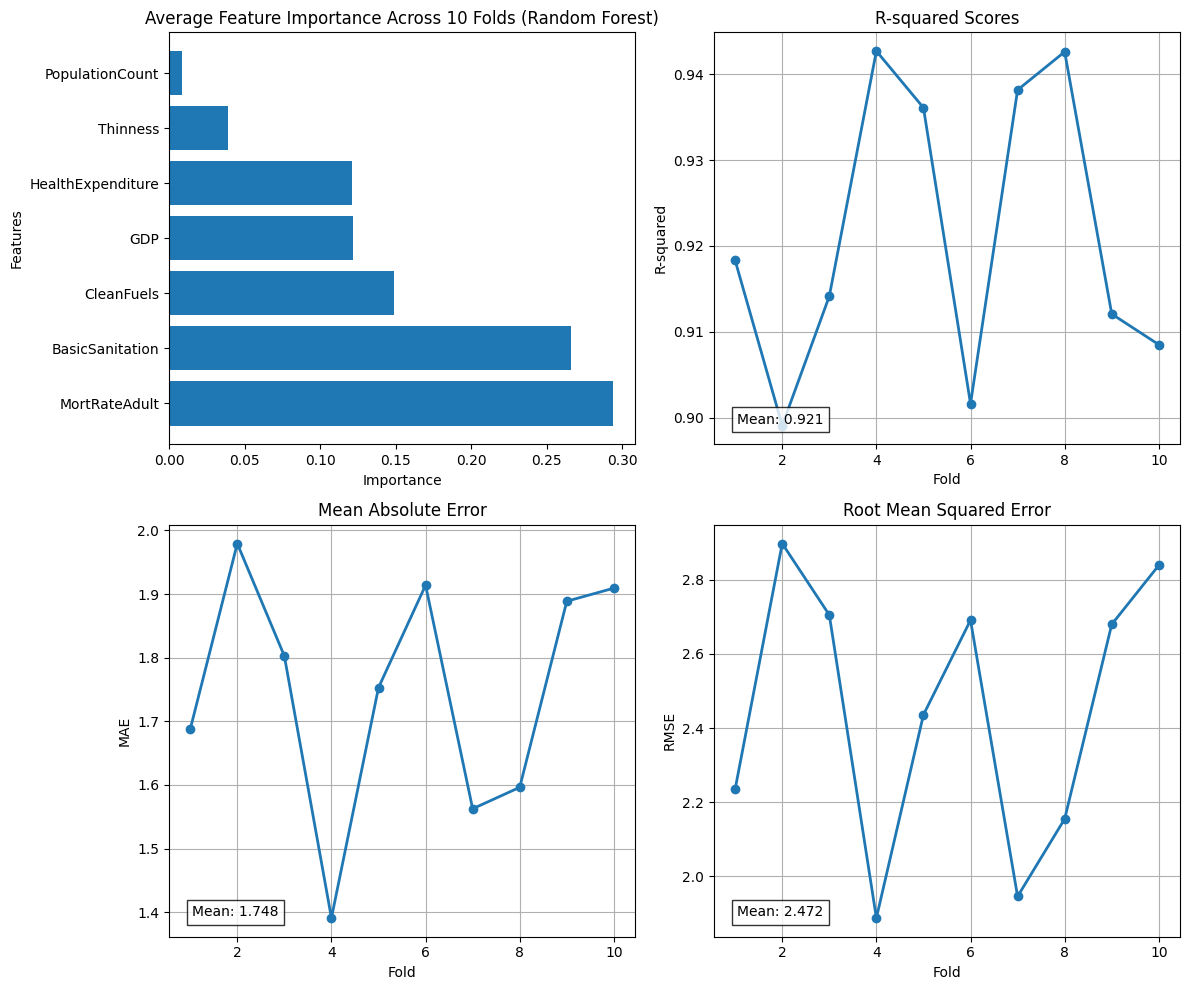

Average R-squared: 0.921 (+/- 0.016)
Average MAE: 1.748 (+/- 0.178)
Average RMSE: 2.472 (+/- 1.296)


In [8]:
# Calculate mean metrics
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.sqrt(np.mean(mse_scores))  # Convert MSE to RMSE
std_r2 = np.std(r2_scores)
std_mae = np.std(mae_scores)
std_rmse = np.sqrt(np.std(mse_scores))  # Convert MSE std to RMSE std

# Convert feature importances to array for easier plotting
feature_importances = np.array(feature_importances)
mean_importance = np.mean(feature_importances, axis=0)

# Sort feature importances in descending order
sorted_idx = np.argsort(mean_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]
sorted_importance = mean_importance[sorted_idx]

# Create a figure with a more square-like size
plt.figure(figsize=(12, 10))

# Feature Importance plot (horizontal bars)
ax0 = plt.subplot(2, 2, 1)
ax0.barh(range(len(sorted_importance)), sorted_importance)
ax0.set_yticks(range(len(sorted_importance)))
ax0.set_yticklabels(sorted_features)
ax0.set_title('Average Feature Importance Across 10 Folds (Random Forest)')
ax0.set_xlabel('Importance')
ax0.set_ylabel('Features')

# R-squared plot
ax1 = plt.subplot(2, 2, 2)
ax1.plot(range(1, 11), r2_scores, marker='o', linewidth=2)
ax1.set_title('R-squared Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('R-squared')
ax1.grid(True)
ax1.text(0.05, 0.05, f'Mean: {mean_r2:.3f}',
         transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# MAE plot
ax2 = plt.subplot(2, 2, 3)
ax2.plot(range(1, 11), mae_scores, marker='o', linewidth=2)
ax2.set_title('Mean Absolute Error')
ax2.set_xlabel('Fold')
ax2.set_ylabel('MAE')
ax2.grid(True)
ax2.text(0.05, 0.05, f'Mean: {mean_mae:.3f}',
         transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# RMSE plot
ax3 = plt.subplot(2, 2, 4)
ax3.plot(range(1, 11), np.sqrt(mse_scores), marker='o', linewidth=2)
ax3.set_title('Root Mean Squared Error')
ax3.set_xlabel('Fold')
ax3.set_ylabel('RMSE')
ax3.grid(True)
ax3.text(0.05, 0.05, f'Mean: {mean_rmse:.3f}',
         transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Make plot tighter
plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average R-squared: {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Average MAE: {mean_mae:.3f} (+/- {std_mae:.3f})")
print(f"Average RMSE: {mean_rmse:.3f} (+/- {std_rmse:.3f})")  # Changed MSE to RMSE

# XGBoost model training


In [9]:
# create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

# select the parameters for XGBoost
params = {
    'max_depth': 3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'dart',
}
# train the model
model = xgb.train(params, dtrain, num_boost_round=50, evals=[(dtest, 'test'), (dval, 'val')], early_stopping_rounds=10)

[0]	test-rmse:6.40736	val-rmse:6.37276


[1]	test-rmse:4.82792	val-rmse:4.82574
[2]	test-rmse:3.76981	val-rmse:3.76417
[3]	test-rmse:3.11776	val-rmse:3.06988
[4]	test-rmse:2.71157	val-rmse:2.64400
[5]	test-rmse:2.44254	val-rmse:2.34969
[6]	test-rmse:2.28678	val-rmse:2.18562
[7]	test-rmse:2.16435	val-rmse:2.07183
[8]	test-rmse:2.10068	val-rmse:1.98308
[9]	test-rmse:2.05770	val-rmse:1.94868
[10]	test-rmse:2.03079	val-rmse:1.90609
[11]	test-rmse:2.01539	val-rmse:1.89396
[12]	test-rmse:1.97127	val-rmse:1.85642
[13]	test-rmse:1.95838	val-rmse:1.84167
[14]	test-rmse:1.94124	val-rmse:1.82844
[15]	test-rmse:1.94128	val-rmse:1.82524
[16]	test-rmse:1.92531	val-rmse:1.81362
[17]	test-rmse:1.90691	val-rmse:1.79779
[18]	test-rmse:1.87977	val-rmse:1.77814
[19]	test-rmse:1.88368	val-rmse:1.77340
[20]	test-rmse:1.87503	val-rmse:1.75724
[21]	test-rmse:1.86664	val-rmse:1.74802
[22]	test-rmse:1.85002	val-rmse:1.74329
[23]	test-rmse:1.84271	val-rmse:1.73902
[24]	test-rmse:1.82343	val-rmse:1.71932
[25]	test-rmse:1.81833	val-rmse:1.71062
[26]	test

# Model validation


In [10]:
# test model
print(type(model))
if(type(model) == xgb.core.Booster):
    y_pred = model.predict(dtest)
else:
    y_pred = model.predict(X_test)

# validate model
if(type(model) == xgb.core.Booster):
    y_val_pred = model.predict(dval)
else:
    y_val_pred = model.predict(X_val)

# get r-sq
if(type(model) == xgb.core.Booster):
    r_sq = r2_score(y_test, y_pred)
    r_sq_val = r2_score(y_val, y_val_pred)
else:
    r_sq = model.score(X_test, y_test)
    r_sq_val = model.score(X_val, y_val)


mse_test = mean_squared_error(y_test, y_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

print(f"Test MSE: {mse_test}")
print(f"Validation MSE: {mse_val}")
print(f"R-sq: {r_sq}")
print(f"Validation R-sq: {r_sq_val}")

<class 'xgboost.core.Booster'>
Test MSE: 2.9095060401931567
Validation MSE: 2.5180008344525584
R-sq: 0.9617733926125336
Validation R-sq: 0.9663331416522857


## Cross validation


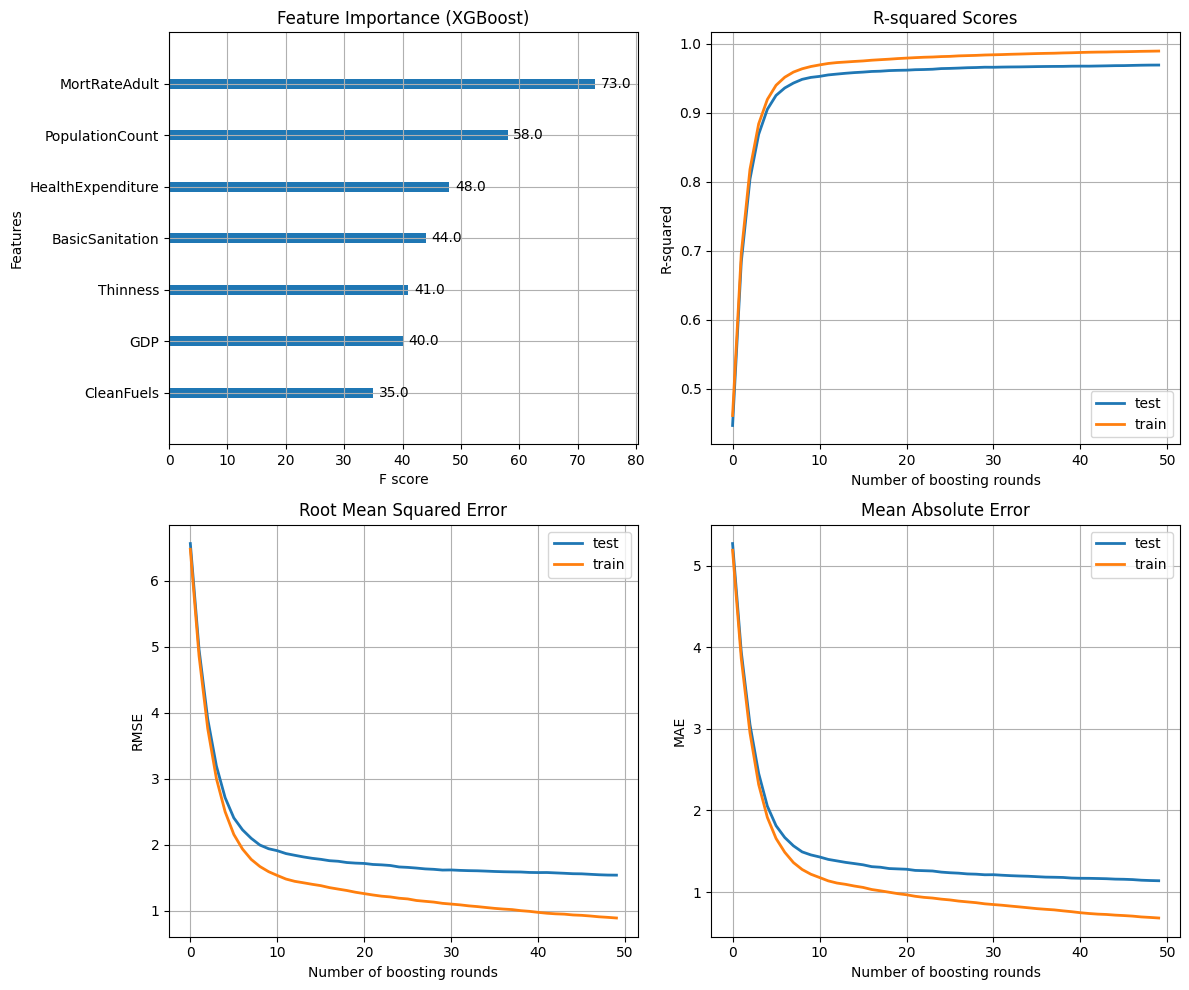

In [11]:
# Create a square figure
plt.figure(figsize=(12, 10))

# Feature Importance plot 
ax0 = plt.subplot(2, 2, 1)
if type(model) == xgb.core.Booster:
    xgb.plot_importance(model, ax=ax0, title='Feature Importance (XGBoost)')
else:
    feature_importance = model.feature_importances_
    ax0.barh(range(len(X_train.columns)), feature_importance)
    ax0.set_yticks(range(len(X_train.columns)))
    ax0.set_yticklabels(X_train.columns)
    ax0.set_title('Feature Importance (XGBoost)')
    ax0.set_xlabel('Importance')
    ax0.set_ylabel('Features')

# R-squared plot
ax1 = plt.subplot(2, 2, 2)
if type(model) == xgb.core.Booster:
    scores = xgb.cv(params, dtrain, num_boost_round=50, nfold=4, early_stopping_rounds=10, metrics='rmse')
    r2_train = 1 - (scores["train-rmse-mean"] ** 2 / np.var(y_train))
    r2_test = 1 - (scores["test-rmse-mean"] ** 2 / np.var(y_train))
    ax1.plot(r2_test, label='test', linewidth=2)
    ax1.plot(r2_train, label='train', linewidth=2)
    ax1.set_xlabel('Number of boosting rounds')
else:
    r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    ax1.plot(range(1, 11), r2_scores, linewidth=2)
    ax1.set_xlabel('Fold')
ax1.set_title('R-squared Scores')
ax1.set_ylabel('R-squared')
ax1.grid(True)
ax1.legend()

# RMSE plot
ax2 = plt.subplot(2, 2, 3)
if type(model) == xgb.core.Booster:
    ax2.plot(scores["test-rmse-mean"], label='test', linewidth=2)
    ax2.plot(scores["train-rmse-mean"], label='train', linewidth=2)
    ax2.set_xlabel('Number of boosting rounds')
else:
    mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    ax2.plot(range(1, 11), rmse_scores, linewidth=2)
    ax2.set_xlabel('Fold')
ax2.set_title('Root Mean Squared Error')
ax2.set_ylabel('RMSE')
ax2.grid(True)
ax2.legend()

# MAE plot
ax3 = plt.subplot(2, 2, 4)
if type(model) == xgb.core.Booster:
    mae_scores = xgb.cv(params, dtrain, num_boost_round=50, nfold=4, early_stopping_rounds=10, metrics='mae')
    ax3.plot(mae_scores["test-mae-mean"], label='test', linewidth=2)
    ax3.plot(mae_scores["train-mae-mean"], label='train', linewidth=2)
    ax3.set_xlabel('Number of boosting rounds')
else:
    mae_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    ax3.plot(range(1, 11), mae_scores, linewidth=2)
    ax3.set_xlabel('Fold')
ax3.set_title('Mean Absolute Error')
ax3.set_ylabel('MAE')
ax3.grid(True)
ax3.legend()

# Adjust layout
plt.tight_layout()
plt.show()